# STAT GR5243 Project 1
### Group 8 :
Baixuan Chen\
Carrie Yan Yin Fen\
Kevin Ma\
Shuzhi Yang

## Data Cleaning and Handling Inconsistencies

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("ibm_jobs.csv")
df.head()

,job_title,job_id,date_posted,state_province,area_of_work,min_salary,max_salary,position_type,required_education,preferred_education,preferred_technical_experience
0,Software Developer Intern 2026: SVL,75759,30-Jan-2026,California,Software Engineering,"90,720.00","166,320.00",Internship,High School Diploma/GED,Bachelor's Degree,"Exposure to cloud platforms (IBM Cloud, AWS, o..."
1,SAP Technology Architect,72352,26-Nov-2025,"Illinois, Texas, Indiana, New Jersey",Software Engineering,"144,000.00","248,000.00",Professional,Bachelor's Degree,NaN,"SAP\nS/4HANA, SAP BTP (CAP, RAP, Event Mesh, I..."
2,"Senior Software Engineer, (Boundary) - HashiCorp",82844,03-Feb-2026,"Texas, Massachusetts, California",Software Engineering,"131,000.00","226,000.00",Professional,High School Diploma/GED,Bachelor's Degree,What's nice to have (preferred qualifications)...
3,DevOps Engineer - AWS,80597,19-Dec-2025,Texas,Infrastructure & Technology,"99,875.00","129,250.00",Professional,Bachelor's Degree,Master's Degree,NaN
4,Federal Senior Compliance Lead - CAS / FAR SME,86235,29-Jan-2026,"Minnesota, New York, Virginia, Maryland, Distr...",Enterprise Operations,"147,000.00","254,000.00",Professional,Bachelor's Degree,Master's Degree,Direct experience with the Defense Contract Au...


#### Convert salary from string to int

In [2]:
for col in ["min_salary", "max_salary"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .replace("nan", np.nan)
        .astype(float)
    )

#### Uniform formatting date posted

In [3]:
df["date_posted"] = pd.to_datetime(df["date_posted"], errors="coerce")

#### Uniform formatting education

In [4]:

edu_cols = ["required_education", "preferred_education"]
for c in edu_cols:
    df[c] = df[c].astype("string").str.strip().str.lower()

edu_map = {
    "high school diploma/ged": "high_school_ged",
    "associate's degree/college diploma": "associate",
    "bachelor's degree": "bachelor",
    "master's degree": "master",
    "doctorate degree": "doctorate",
    "technical diploma": "technical_diploma",
}

for c in edu_cols:
    df[c] = df[c].map(edu_map).fillna("unknown")

#### Drop duplicates

In [5]:
df = df.drop_duplicates().reset_index(drop=True)

#### create mean salary col

In [6]:
df["salary_mid"] = (df["min_salary"] + df["max_salary"]) / 2

#### Handle Missing Values

In [7]:
df.isna().sum()

job_title                          1
job_id                             0
date_posted                        0
state_province                     0
area_of_work                       5
min_salary                         1
max_salary                         1
position_type                      0
required_education                 0
preferred_education                0
preferred_technical_experience    92
salary_mid                         1
dtype: int64

In [8]:
df = df.dropna(subset=["min_salary", "max_salary", "job_title"])
df["preferred_technical_experience"] = (
    df["preferred_technical_experience"].fillna("")
)
df["area_of_work"] = (
    df["area_of_work"].fillna("unknown")
)

#### Cleaned Data Overview

In [ ]:
df.info()
df.head()

# EDA

# 1. Data Overview & Quality Checks

This section summarizes the structure and reliability of the scraped IBM job-posting dataset before deeper analysis. The raw dataset contains 478 rows × 11 columns. After basic normalization (string trimming), type conversions (posting date to datetime; salary strings to numeric), and derived features (midpoint salary and salary range), we create an analysis-ready table and remove duplicate postings based on job_id, resulting in 471 unique postings.

Data types and parsing quality are checked first: date_posted is fully parsed into date_posted_dt with 0 unparsed dates, and salary parsing yields only 1 missing value in min_salary_num and 1 in max_salary_num. We then assess missingness and find that missing values are concentrated in optional “preferred” fields (preferred_education and preferred_technical_experience), while core identifiers and posting date are complete. Finally, duplicate and validity checks indicate that only 7 exact duplicate rows (and 7 duplicate job_id values) exist; salary logic checks show 0 cases where min_salary_num exceeds max_salary_num, and there are no non-positive salary values.

All subsequent EDA sections primarily use the de-duplicated dataset (df_eda) to avoid double-counting postings.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# Locate CSV file
candidates = [
    Path("C:/Users/win/PycharmProjects/pythonProject/5243/5243-Project1/ibm_jobs.csv"),
]

DATA_PATH = None
for p in candidates:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError("Cannot find ibm_jobs.csv.")

print("Using data file:", DATA_PATH)


#Read raw data
df_raw = pd.read_csv(DATA_PATH)
print("df_raw shape:", df_raw.shape)

df_raw.head()

## 1.1 Field Inspection and Minimal Type Conversions

Several fields require minimal but essential preprocessing to support reliable summaries and visualizations. The posting date field date_posted follows the format like 30-Jan-2026 and is converted into date_posted_dt; parsing is fully successful with 0 NaT, which enables trend analyses over time. The salary fields min_salary and max_salary are stored as strings with commas (for example, 90,720.00), so they are converted into numeric columns min_salary_num and max_salary_num; only one record fails parsing for each salary column.

We also construct derived salary features mid_salary = (min + max) / 2 and salary_range = max − min, which will be used for distribution plots and group comparisons. Finally, we apply basic text normalization by stripping whitespace from all string-like columns to improve the reliability of category counting. This preprocessing is intentionally lightweight: it preserves the original information while making the dataset analysis-ready.


In [3]:
df = df_raw.copy()

#  Strip whitespace for all object columns (basic text normalization)
obj_cols = df.select_dtypes(include="object").columns
for c in obj_cols:
    df[c] = df[c].astype("string").str.strip()

# Parse date_posted
# Example format observed: "30-Jan-2026"
df["date_posted_dt"] = pd.to_datetime(df["date_posted"], format="%d-%b-%Y", errors="coerce")

# Convert salary columns to numeric
# Remove anything that's not digit/./-
def to_numeric_money(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    s = s.str.replace(r"[^0-9\.\-]", "", regex=True)  # remove commas/$/spaces etc.
    s = s.replace("", pd.NA)
    return pd.to_numeric(s, errors="coerce")

df["min_salary_num"] = to_numeric_money(df["min_salary"])
df["max_salary_num"] = to_numeric_money(df["max_salary"])

df["mid_salary"] = (df["min_salary_num"] + df["max_salary_num"]) / 2
df["salary_range"] = df["max_salary_num"] - df["min_salary_num"]

# check
df[["date_posted", "date_posted_dt", "min_salary", "min_salary_num", "max_salary", "max_salary_num"]].head()

C:\Users\win\AppData\Local\Temp\ipykernel_38676\1597034129.py:4: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = df.select_dtypes(include="object").columns


,date_posted,date_posted_dt,min_salary,min_salary_num,max_salary,max_salary_num
0,30-Jan-2026,2026-01-30,"90,720.00",90720.0,"166,320.00",166320.0
1,26-Nov-2025,2025-11-26,"144,000.00",144000.0,"248,000.00",248000.0
2,03-Feb-2026,2026-02-03,"131,000.00",131000.0,"226,000.00",226000.0
3,19-Dec-2025,2025-12-19,"99,875.00",99875.0,"129,250.00",129250.0
4,29-Jan-2026,2026-01-29,"147,000.00",147000.0,"254,000.00",254000.0


In [4]:
print("Basic info")
display(df.head(3))

print("\nDtypes (raw vs converted)")
dtypes_table = pd.DataFrame({
    "raw_dtype": df_raw.dtypes.astype(str),
    "cleaned_dtype": df.dtypes.astype(str)
})
display(dtypes_table)

print("\nMissingness (raw columns)")
missing_counts = df_raw.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df_raw) * 100).round(2)
missing_table = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct})
display(missing_table)

print("\nMissingness (key converted columns)")
conv_missing = df[["date_posted_dt", "min_salary_num", "max_salary_num"]].isna().sum()
display(conv_missing.to_frame("missing_count"))


Basic info


,job_title,job_id,date_posted,state_province,area_of_work,min_salary,max_salary,position_type,required_education,preferred_education,preferred_technical_experience,date_posted_dt,min_salary_num,max_salary_num,mid_salary,salary_range
0,Software Developer Intern 2026: SVL,75759,30-Jan-2026,California,Software Engineering,"90,720.00","166,320.00",Internship,High School Diploma/GED,Bachelor's Degree,"Exposure to cloud platforms (IBM Cloud, AWS, o...",2026-01-30,90720.0,166320.0,128520.0,75600.0
1,SAP Technology Architect,72352,26-Nov-2025,"Illinois, Texas, Indiana, New Jersey",Software Engineering,"144,000.00","248,000.00",Professional,Bachelor's Degree,<NA>,"SAP\nS/4HANA, SAP BTP (CAP, RAP, Event Mesh, I...",2025-11-26,144000.0,248000.0,196000.0,104000.0
2,"Senior Software Engineer, (Boundary) - HashiCorp",82844,03-Feb-2026,"Texas, Massachusetts, California",Software Engineering,"131,000.00","226,000.00",Professional,High School Diploma/GED,Bachelor's Degree,What's nice to have (preferred qualifications)...,2026-02-03,131000.0,226000.0,178500.0,95000.0



Dtypes (raw vs converted)


,raw_dtype,cleaned_dtype
area_of_work,str,string
date_posted,str,string
date_posted_dt,NaN,datetime64[us]
job_id,int64,int64
job_title,str,string
max_salary,str,string
max_salary_num,NaN,Float64
mid_salary,NaN,Float64
min_salary,str,string
min_salary_num,NaN,Float64



Missingness (raw columns)


,missing_count,missing_pct
preferred_education,123,25.73
preferred_technical_experience,92,19.25
required_education,12,2.51
area_of_work,5,1.05
min_salary,1,0.21
job_title,1,0.21
max_salary,1,0.21
date_posted,0,0.00
job_id,0,0.00
state_province,0,0.00



Missingness (key converted columns)


,missing_count
date_posted_dt,0
min_salary_num,1
max_salary_num,1


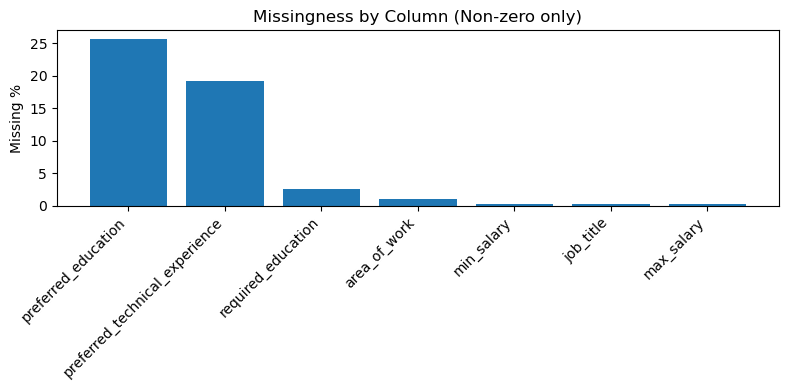

preferred_education               25.732218
preferred_technical_experience    19.246862
required_education                 2.510460
area_of_work                       1.046025
min_salary                         0.209205
job_title                          0.209205
max_salary                         0.209205
dtype: float64

In [5]:
# Missingness bar plot (top columns with missing)
miss = (df_raw.isna().mean() * 100).sort_values(ascending=False)
miss_nonzero = miss[miss > 0]

plt.figure(figsize=(8, 4))
plt.bar(miss_nonzero.index, miss_nonzero.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing %")
plt.title("Missingness by Column (Non-zero only)")
plt.tight_layout()
plt.show()

miss_nonzero


In [6]:
n_rows = len(df_raw)

dup_rows = df_raw.duplicated().sum()
dup_jobid = df_raw["job_id"].duplicated().sum()
n_unique_jobid = df_raw["job_id"].nunique()

print("Duplicate checks")
print(f"Total rows: {n_rows}")
print(f"Duplicated rows (exact duplicates): {dup_rows}")
print(f"Duplicated job_id count: {dup_jobid}")
print(f"Unique job_id: {n_unique_jobid}")

# Show duplicated job_id examples
dup_examples = df_raw[df_raw["job_id"].duplicated(keep=False)].sort_values("job_id")
display(dup_examples[["job_id", "job_title", "date_posted", "state_province"]].head(20))


Duplicate checks
Total rows: 478
Duplicated rows (exact duplicates): 7
Duplicated job_id count: 7
Unique job_id: 471


,job_id,job_title,date_posted,state_province
364,56278,Entry Level Product Manager 2026,13-Nov-2025,"Georgia, Minnesota, Texas, New York, North Car..."
367,56278,Entry Level Product Manager 2026,13-Nov-2025,"Georgia, Minnesota, Texas, New York, North Car..."
368,72727,Network and Computer Systems Administrator App...,04-Dec-2025,New York
365,72727,Network and Computer Systems Administrator App...,04-Dec-2025,New York
369,75078,Cloud Developer Intern,06-Jan-2026,"Illinois, Texas, North Carolina, California"
366,75078,Cloud Developer Intern,06-Jan-2026,"Illinois, Texas, North Carolina, California"
162,75693,Technical Lead TS/SCI W/FSP,09-Dec-2025,"Virginia, Maryland, District of Columbia"
141,75693,Technical Lead TS/SCI W/FSP,09-Dec-2025,"Virginia, Maryland, District of Columbia"
292,87213,Associate Package Consultant Intern 2026 – SAP...,30-Jan-2026,"Georgia, Illinois, Texas, Virginia, Arizona"
313,87213,Associate Package Consultant Intern 2026 – SAP...,30-Jan-2026,"Georgia, Illinois, Texas, Virginia, Arizona"


In [7]:
print("Validity checks")

# date parsing success
n_bad_date = df["date_posted_dt"].isna().sum()
date_min = df["date_posted_dt"].min()
date_max = df["date_posted_dt"].max()
print(f"Unparsed dates (NaT): {n_bad_date}")
print(f"Date range: {date_min.date()} to {date_max.date()}")

# salary numeric success
n_bad_min = df["min_salary_num"].isna().sum()
n_bad_max = df["max_salary_num"].isna().sum()
print(f"Unparsed min_salary_num: {n_bad_min}")
print(f"Unparsed max_salary_num: {n_bad_max}")

# logical constraints
min_gt_max = (df["min_salary_num"] > df["max_salary_num"]).sum()
min_le_0 = (df["min_salary_num"] <= 0).sum()
max_le_0 = (df["max_salary_num"] <= 0).sum()
print(f"Rows with min_salary_num > max_salary_num: {min_gt_max}")
print(f"Rows with min_salary_num <= 0: {min_le_0}")
print(f"Rows with max_salary_num <= 0: {max_le_0}")

# salary summary (robust quantiles)
salary_desc = df[["min_salary_num", "max_salary_num", "mid_salary", "salary_range"]].describe(percentiles=[.01, .05, .5, .95, .99]).T
display(salary_desc)


Validity checks
Unparsed dates (NaT): 0
Date range: 2025-08-14 to 2026-02-04
Unparsed min_salary_num: 1
Unparsed max_salary_num: 1
Rows with min_salary_num > max_salary_num: 0
Rows with min_salary_num <= 0: 0
Rows with max_salary_num <= 0: 0


,count,mean,std,min,1%,5%,50%,95%,99%,max
min_salary_num,477.0,105427.475891,37356.620459,29120.0,36040.0,49200.0,99875.0,161000.0,206870.4,275000.0
max_salary_num,477.0,176848.549266,60766.984719,38000.0,54120.0,79440.0,172000.0,270400.0,318680.0,410000.0
mid_salary,477.0,141138.012579,48240.133708,35500.0,49940.0,63672.0,134000.0,218500.0,256500.0,342500.0
salary_range,477.0,71421.073375,29459.209882,0.0,4920.0,26480.0,69900.0,115000.0,133480.0,216000.0


In [8]:
# Keep raw cleaned df as df_clean
df_clean = df.copy()

# Create analysis dataset: drop duplicates by job_id
before = len(df_clean)
df_eda = df_clean.drop_duplicates(subset=["job_id"], keep="first").reset_index(drop=True)
after = len(df_eda)

print("Build df_eda:")
print(f"Rows before de-dup by job_id: {before}")
print(f"Rows after  de-dup by job_id: {after}")
print(f"Removed rows: {before - after}")

df_eda.head()


Build df_eda:
Rows before de-dup by job_id: 478
Rows after  de-dup by job_id: 471
Removed rows: 7


,job_title,job_id,date_posted,state_province,area_of_work,min_salary,max_salary,position_type,required_education,preferred_education,preferred_technical_experience,date_posted_dt,min_salary_num,max_salary_num,mid_salary,salary_range
0,Software Developer Intern 2026: SVL,75759,30-Jan-2026,California,Software Engineering,"90,720.00","166,320.00",Internship,High School Diploma/GED,Bachelor's Degree,"Exposure to cloud platforms (IBM Cloud, AWS, o...",2026-01-30,90720.0,166320.0,128520.0,75600.0
1,SAP Technology Architect,72352,26-Nov-2025,"Illinois, Texas, Indiana, New Jersey",Software Engineering,"144,000.00","248,000.00",Professional,Bachelor's Degree,<NA>,"SAP\nS/4HANA, SAP BTP (CAP, RAP, Event Mesh, I...",2025-11-26,144000.0,248000.0,196000.0,104000.0
2,"Senior Software Engineer, (Boundary) - HashiCorp",82844,03-Feb-2026,"Texas, Massachusetts, California",Software Engineering,"131,000.00","226,000.00",Professional,High School Diploma/GED,Bachelor's Degree,What's nice to have (preferred qualifications)...,2026-02-03,131000.0,226000.0,178500.0,95000.0
3,DevOps Engineer - AWS,80597,19-Dec-2025,Texas,Infrastructure & Technology,"99,875.00","129,250.00",Professional,Bachelor's Degree,Master's Degree,<NA>,2025-12-19,99875.0,129250.0,114562.5,29375.0
4,Federal Senior Compliance Lead - CAS / FAR SME,86235,29-Jan-2026,"Minnesota, New York, Virginia, Maryland, Distr...",Enterprise Operations,"147,000.00","254,000.00",Professional,Bachelor's Degree,Master's Degree,Direct experience with the Defense Contract Au...,2026-01-29,147000.0,254000.0,200500.0,107000.0


## 1.2 Key Findings from Data Quality Checks

After cleaning and de-duplication, the analysis dataset contains 471 unique job postings (from 478 rows; 7 duplicates removed).

Missingness is concentrated in a small number of columns. preferred_education is missing in 123 out of 478 rows (25.73%), and preferred_technical_experience is missing in 92 out of 478 rows (19.25%). required_education has 12 missing values (2.51%), while other fields are at or below roughly 1% missing; job_id and date_posted are complete with 0% missing. In terms of time coverage, postings span 2025-08-14 to 2026-02-04, and the date parser produces 0 unparsed dates.

Salary validity checks reveal no logical inconsistencies: there are 0 cases where min_salary_num exceeds max_salary_num, and there are no non-positive salaries. On the de-duplicated data, min_salary_num has a minimum of 29,120 and a mean around 105,427; max_salary_num reaches up to 410,000; mid_salary has a median around 134,000 and a mean around 141,138. Finally, the location field state_province often contains multiple states in one posting; about 62.34% of records include comma-separated multi-state strings, so state-level summaries require careful handling.


In [9]:
# Prepare summary numbers from df_raw / df_eda
n, p = df_raw.shape
miss_tbl = (df_raw.isna().sum().to_frame("missing_count"))
miss_tbl["missing_pct"] = (miss_tbl["missing_count"] / n * 100).round(2)
top_miss = miss_tbl.sort_values("missing_pct", ascending=False).head(5)

multi_state_pct = (df_raw["state_province"].astype(str).str.contains(",").mean() * 100)

salary_min = df_eda["min_salary_num"].min()
salary_max = df_eda["max_salary_num"].max()
mid_med = df_eda["mid_salary"].median()

summary_md = f"""
- Dataset size: {n} rows × {p} columns
- Duplicates: {df_raw["job_id"].nunique()} unique `job_id` values; {df_raw["job_id"].duplicated().sum()} duplicated `job_id` records detected
- Missing values (Top):
{top_miss.to_string()}

Date range: {df_eda["date_posted_dt"].min().date()} to {df_eda["date_posted_dt"].max().date()} (number of unparseable dates: {df_eda["date_posted_dt"].isna().sum()})
Salary range (after deduplication): minimum of `min_salary_num` = {salary_min:,.0f}, maximum of `max_salary_num` = {salary_max:,.0f}; median of `mid_salary` = {mid_med:,.0f}
Proportion of multi-state information in `state_province`: approximately {multi_state_pct:.2f}%
""".strip()


print(summary_md)


- Dataset size: 478 rows × 11 columns
- Duplicates: 471 unique `job_id` values; 7 duplicated `job_id` records detected
- Missing values (Top):
                                missing_count  missing_pct
preferred_education                       123        25.73
preferred_technical_experience             92        19.25
required_education                         12         2.51
area_of_work                                5         1.05
min_salary                                  1         0.21

Date range: 2025-08-14 to 2026-02-04 (number of unparseable dates: 0)
Salary range (after deduplication): minimum of `min_salary_num` = 29,120, maximum of `max_salary_num` = 410,000; median of `mid_salary` = 134,000
Proportion of multi-state information in `state_province`: approximately 62.34%


# 2. Univariate Analysis

This section examines one variable at a time to understand marginal distributions and identify dominant categories or long-tail patterns. All results are based on the de-duplicated dataset (471 postings) to avoid double-counting.

We focus on categorical distributions (counts and shares) for position_type, area_of_work, and education-related fields; we also summarize state_province while keeping in mind that many entries contain multiple states. For salary distributions, we use numeric salary features (min_salary_num, max_salary_num, mid_salary, salary_range) and visually inspect skewness and potential outliers. These univariate results help determine which dimensions are most informative for later bivariate analyses.

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# use df_eda to do EDA remained
df2 = df_eda.copy()

print("df2 shape:", df2.shape)
df2.head()


df2 shape: (471, 16)


,job_title,job_id,date_posted,state_province,area_of_work,min_salary,max_salary,position_type,required_education,preferred_education,preferred_technical_experience,date_posted_dt,min_salary_num,max_salary_num,mid_salary,salary_range
0,Software Developer Intern 2026: SVL,75759,30-Jan-2026,California,Software Engineering,"90,720.00","166,320.00",Internship,High School Diploma/GED,Bachelor's Degree,"Exposure to cloud platforms (IBM Cloud, AWS, o...",2026-01-30,90720.0,166320.0,128520.0,75600.0
1,SAP Technology Architect,72352,26-Nov-2025,"Illinois, Texas, Indiana, New Jersey",Software Engineering,"144,000.00","248,000.00",Professional,Bachelor's Degree,<NA>,"SAP\nS/4HANA, SAP BTP (CAP, RAP, Event Mesh, I...",2025-11-26,144000.0,248000.0,196000.0,104000.0
2,"Senior Software Engineer, (Boundary) - HashiCorp",82844,03-Feb-2026,"Texas, Massachusetts, California",Software Engineering,"131,000.00","226,000.00",Professional,High School Diploma/GED,Bachelor's Degree,What's nice to have (preferred qualifications)...,2026-02-03,131000.0,226000.0,178500.0,95000.0
3,DevOps Engineer - AWS,80597,19-Dec-2025,Texas,Infrastructure & Technology,"99,875.00","129,250.00",Professional,Bachelor's Degree,Master's Degree,<NA>,2025-12-19,99875.0,129250.0,114562.5,29375.0
4,Federal Senior Compliance Lead - CAS / FAR SME,86235,29-Jan-2026,"Minnesota, New York, Virginia, Maryland, Distr...",Enterprise Operations,"147,000.00","254,000.00",Professional,Bachelor's Degree,Master's Degree,Direct experience with the Defense Contract Au...,2026-01-29,147000.0,254000.0,200500.0,107000.0


## 2.1 Helper Function: Top-N Category Plots (Counts + Percentages)

To streamline categorical EDA, we define a reusable plotting function that computes value counts and percent shares for a given categorical column. When the category space is long-tailed, the function can optionally aggregate low-frequency categories into “Other” to keep plots readable. It returns a summary table alongside a bar chart, and we apply it consistently across position_type, area_of_work, and education-related fields to ensure comparable summaries.


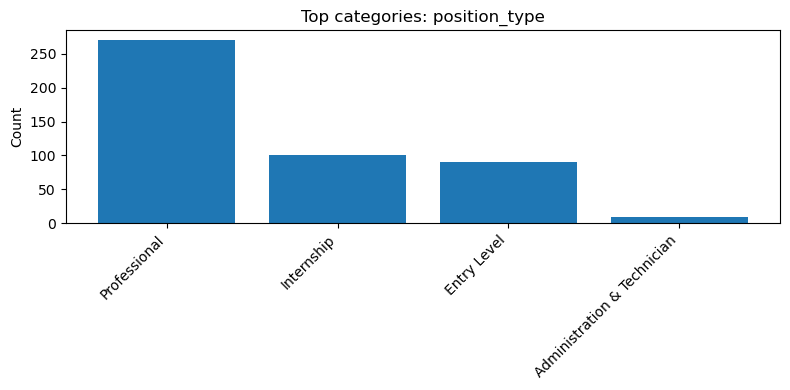

,count,pct(%)
position_type,,
Professional,271,57.54
Internship,100,21.23
Entry Level,90,19.11
Administration & Technician,10,2.12


In [11]:
def plot_top_categories(df, col, top_n=10, other=True, figsize=(8,4)):
    s = df[col].dropna().astype(str).str.strip()
    vc = s.value_counts(dropna=True)

    if other and len(vc) > top_n:
        top = vc.iloc[:top_n]
        other_sum = vc.iloc[top_n:].sum()
        vc_plot = pd.concat([top, pd.Series({"Other": other_sum})])
    else:
        vc_plot = vc.iloc[:top_n]

    pct = (vc_plot / vc_plot.sum() * 100).round(2)
    out = pd.DataFrame({"count": vc_plot, "pct(%)": pct})

    # plot
    plt.figure(figsize=figsize)
    plt.bar(out.index, out["count"].values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")
    plt.title(f"Top categories: {col}")
    plt.tight_layout()
    plt.show()

    return out

# quick test
plot_top_categories(df2, "position_type", top_n=10, other=False)


## 2.2 Categorical Distributions

For position_type, the dataset is dominated by professional roles. Professional accounts for 271 postings (57.54%), while Internship and Entry Level represent substantial shares with 100 (21.23%) and 90 (19.11%) postings, respectively; Administration & Technician is rare (10; 2.12%). This composition suggests the scraped postings primarily reflect professional hiring while still capturing a meaningful fraction of internship and entry-level openings.

For area_of_work, the largest functional groups are Consulting (116; 24.89%), Software Engineering (102; 21.9%), and Infrastructure & Technology (100; 21.5%), followed by Sales (41; 8.9%) and smaller long-tail categories. Overall, the dataset shows strong representation of technology- and consulting-related roles.

For education requirements, required_education is concentrated in two categories: Bachelor's Degree (222; 48.26%) and High School Diploma/GED (218; 47.39%), while advanced degrees appear infrequently (for example, Master's Degree 8; 1.74%). For preferred_education (when provided), Bachelor's Degree (240; 68.97%) and Master's Degree (72; 20.69%) dominate, consistent with the earlier observation that preferred fields have higher missingness and are not always specified.


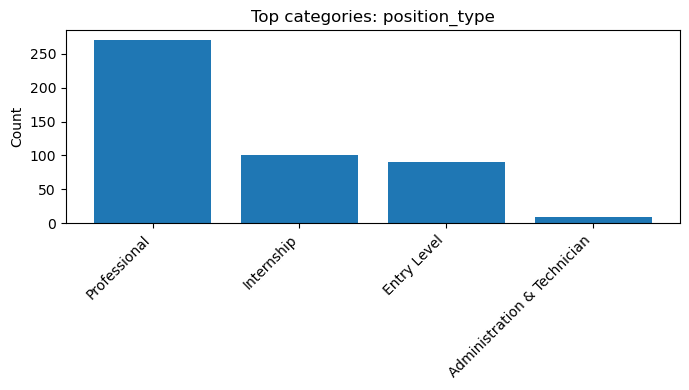

,count,pct(%)
position_type,,
Professional,271,57.54
Internship,100,21.23
Entry Level,90,19.11
Administration & Technician,10,2.12


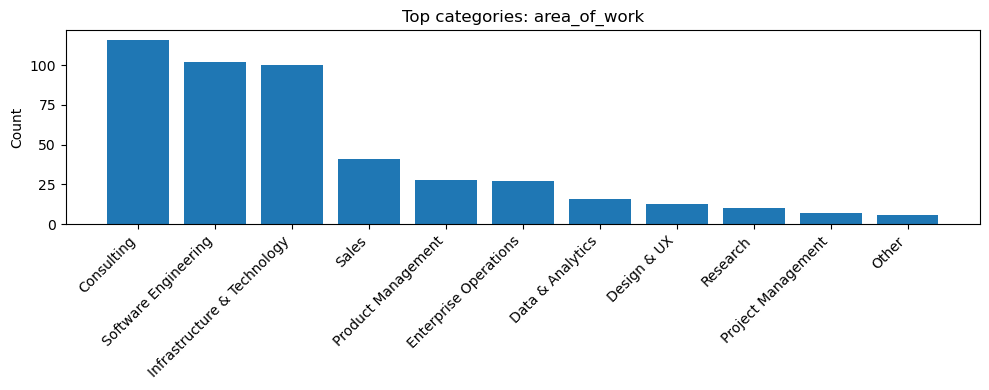

,count,pct(%)
Consulting,116,24.89
Software Engineering,102,21.89
Infrastructure & Technology,100,21.46
Sales,41,8.80
Product Management,28,6.01
Enterprise Operations,27,5.79
Data & Analytics,16,3.43
Design & UX,13,2.79
Research,10,2.15
Project Management,7,1.50


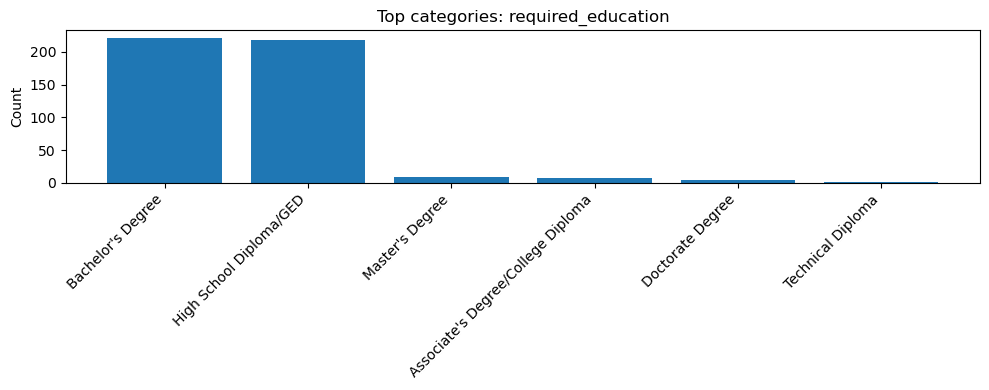

,count,pct(%)
required_education,,
Bachelor's Degree,222,48.26
High School Diploma/GED,218,47.39
Master's Degree,8,1.74
Associate's Degree/College Diploma,7,1.52
Doctorate Degree,4,0.87
Technical Diploma,1,0.22


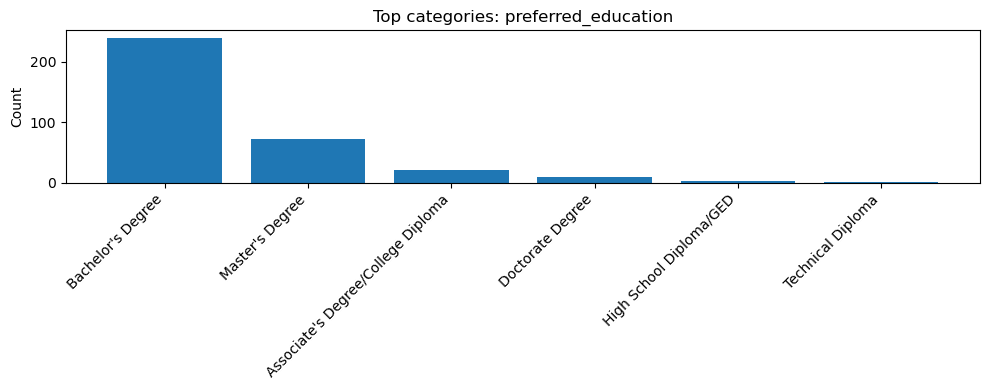

,count,pct(%)
preferred_education,,
Bachelor's Degree,240,68.97
Master's Degree,72,20.69
Associate's Degree/College Diploma,21,6.03
Doctorate Degree,10,2.87
High School Diploma/GED,3,0.86
Technical Diploma,2,0.57


In [12]:
tab_position = plot_top_categories(df2, "position_type", top_n=10, other=True, figsize=(7,4))
display(tab_position)

tab_area = plot_top_categories(df2, "area_of_work", top_n=10, other=True, figsize=(10,4))
display(tab_area)

tab_reqedu = plot_top_categories(df2, "required_education", top_n=10, other=False, figsize=(10,4))
display(tab_reqedu)

tab_prefedu = plot_top_categories(df2, "preferred_education", top_n=10, other=True, figsize=(10,4))
display(tab_prefedu)


## 2.3 Location Field: state_province

The state_province field is not a clean single-state variable. A large share of postings include comma-separated multi-state strings (62.34%), meaning one posting may list multiple potential locations or recruiting regions. When we treat the raw string as a category, it helps summarize common location patterns but can produce long labels, especially for multi-state combinations; it also means that posting-level counts reflect “location strings” rather than individual states.

In the posting-level summary (with truncated labels for readability), New York appears most frequently (61 postings), and multi-state combinations such as Texas, Massachusetts, California (34) also occur often. Any true state distribution should therefore split and explode multi-state entries in a dedicated state-level analysis.

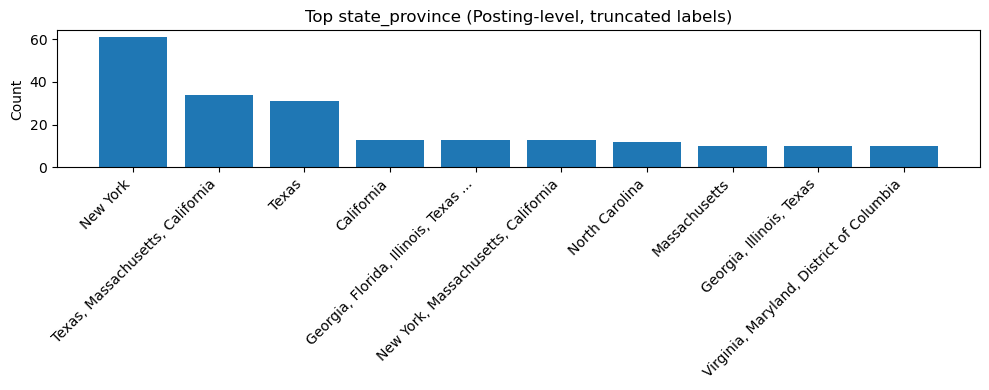

,count
New York,61
"Texas, Massachusetts, California",34
Texas,31
California,13
"Georgia, Florida, Illinois, Texas ...",13
"New York, Massachusetts, California",13
North Carolina,12
Massachusetts,10
"Georgia, Illinois, Texas",10
"Virginia, Maryland, District of Columbia",10


In [13]:
# Posting-level (raw field)

def truncate_states(label, max_states=4):
    parts = [x.strip() for x in str(label).split(",")]
    if len(parts) > max_states:
        return ", ".join(parts[:max_states]) + " ..."
    else:
        return ", ".join(parts)

# original frequency
state_raw_series = df2["state_province"].dropna().astype(str).str.strip()
vc_raw = state_raw_series.value_counts()

# Top N
top_n = 10
vc_plot = vc_raw.iloc[:top_n]

# truncate long label
vc_plot.index = [truncate_states(x, max_states=4) for x in vc_plot.index]

plt.figure(figsize=(10,4))
plt.bar(vc_plot.index, vc_plot.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Top state_province (Posting-level, truncated labels)")
plt.tight_layout()
plt.show()

display(vc_plot.to_frame("count"))


## 2.4 Salary Variables: Distributions

We analyze numeric salary features derived from the scraped salary strings, including min_salary_num and max_salary_num as endpoints, mid_salary as the midpoint, and salary_range as the spread. Key descriptive statistics on the de-duplicated postings with valid salaries indicate that min_salary_num ranges from 29,120 to 275,000 (mean = 105,658), while max_salary_num reaches up to 410,000, suggesting a right tail of high-paying postings. mid_salary has a mean aounrd 141,482, consistent with a right-skewed distribution, and salary_range can be 0 for some postings (fixed endpoints) while extending to large spreads (up to 216,000), indicating heterogeneous pay ranges across roles.

We visualize these distributions using histograms and boxplots; when a log transform is used, it helps interpret skewness and reduces the influence of extreme values.

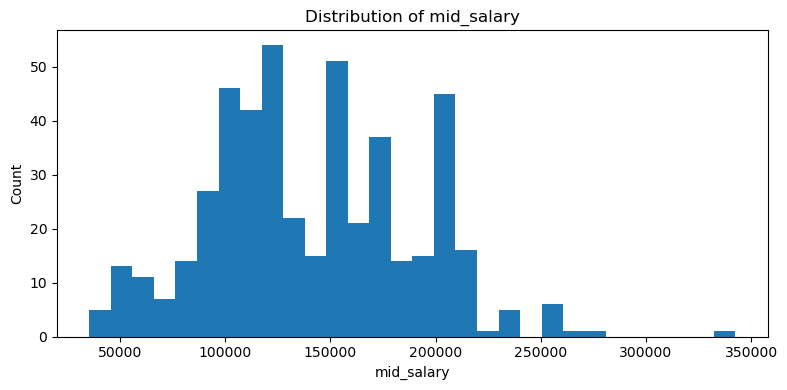

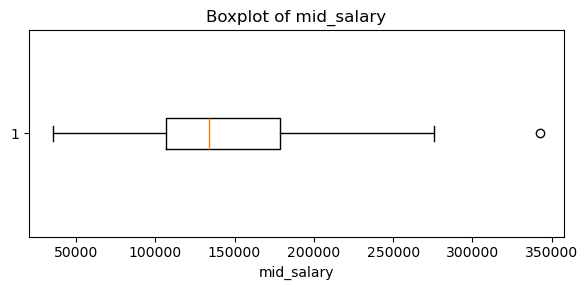

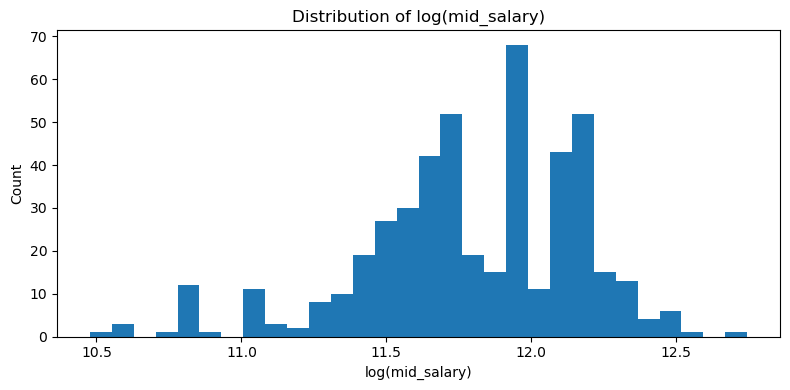

,count,mean,std,min,1%,5%,50%,95%,99%,max
min_salary_num,470.0,105658.310638,37358.188019,29120.0,35760.0,49200.0,100400.0,161000.0,207987.6,275000.0
max_salary_num,470.0,177305.229787,60605.53299,38000.0,54120.0,79728.0,172000.0,271100.0,319170.0,410000.0
mid_salary,470.0,141481.770213,48151.807308,35500.0,49485.0,64071.75,134000.0,218500.0,256500.0,342500.0
salary_range,470.0,71646.919149,29375.899884,0.0,4920.0,26714.0,69950.0,115000.0,133620.0,216000.0


In [14]:
salary_df = df2.dropna(subset=["mid_salary"]).copy()

# 1) Histogram of mid_salary
plt.figure(figsize=(8,4))
plt.hist(salary_df["mid_salary"], bins=30)
plt.xlabel("mid_salary")
plt.ylabel("Count")
plt.title("Distribution of mid_salary")
plt.tight_layout()
plt.show()

# 2) Boxplot of mid_salary
plt.figure(figsize=(6,3))
plt.boxplot(salary_df["mid_salary"], vert=False)
plt.xlabel("mid_salary")
plt.title("Boxplot of mid_salary")
plt.tight_layout()
plt.show()

# 3) Log histogram (add 1 to be safe, though salary should be >0)
salary_df["log_mid_salary"] = np.log(salary_df["mid_salary"])

plt.figure(figsize=(8,4))
plt.hist(salary_df["log_mid_salary"], bins=30)
plt.xlabel("log(mid_salary)")
plt.ylabel("Count")
plt.title("Distribution of log(mid_salary)")
plt.tight_layout()
plt.show()

salary_df[["min_salary_num","max_salary_num","mid_salary","salary_range"]].describe(percentiles=[.01,.05,.5,.95,.99]).T


## 2.5 Conclusion

After removing duplicate job_id entries, the dataset contains 471 unique postings; the posting date parses cleanly, and only a very small number of salary strings fail numeric parsing. Missingness is concentrated in “nice-to-have” fields: preferred_education is missing for about a quarter of postings and preferred_technical_experience for about a fifth, while required_education and the core structural fields have low missingness, so downstream analysis is more reliable when anchored on “required” fields and uses “preferred” fields as supplementary context.

The location field state_province frequently lists multiple states (roughly over 60%), so frequency counts on the raw string represent “location strings” rather than single-state distributions, and the reporting unit should be stated explicitly.

The salary distribution is right-skewed with a small number of high-salary roles, making median and quantiles more robust than the mean; a log transform can be helpful for visualization and modeling.


# 3. Bivariate & Multivariate Analysis

This section focuses on salary differences across key job attributes, comparing compensation across area_of_work, position_type, and education requirements. Because salary is right-skewed with potential extremes, the analysis emphasizes medians and quantiles, and uses nonparametric tests (Kruskal–Wallis) for robust group comparisons; for relationships between categorical variables, chi-square tests and Cramér’s V are used to summarize statistical significance and association strength.


In [15]:
# Base dataset for relationship analysis
df3 = df2.copy()

# Keep rows with salary available
df3_salary = df3.dropna(subset=["mid_salary"]).copy()

# Optional: log salary for robustness
df3_salary["log_mid_salary"] = np.log(df3_salary["mid_salary"])

print("df3_salary shape:", df3_salary.shape)
df3_salary[["mid_salary", "log_mid_salary"]].describe()


df3_salary shape: (470, 17)


,mid_salary,log_mid_salary
count,470.0,470.0
mean,141481.770213,11.795587
std,48151.807308,0.374807
min,35500.0,10.477288
25%,107100.0,11.581518
50%,134000.0,11.805595
75%,178500.0,12.092344
max,342500.0,12.744027


## 3.1 Salary Differences Across area_of_work

Salary differs meaningfully across business areas. Using medians as a robust summary, Consulting and Software Engineering sit at the high end (roughly 157k and 154k), Sales / Design & UX / Product Management fall in the middle, while Infrastructure & Technology shows a lower median among the major groups. The Kruskal–Wallis test is statistically significant (H≈67.25, p≈5.30e-12), indicating that the observed cross-area salary differences are unlikely to be due to random variation; follow-up stratification by position type and geography can help interpret why.


,n,median,mean
area_of_work,,,
Consulting,116,158000.0,157335.258621
Software Engineering,102,151000.0,153866.828431
Sales,41,134000.0,153295.853659
Design & UX,13,126000.0,141689.846154
Product Management,28,123000.0,139805.535714
Data & Analytics,16,118114.5,131634.6875
Enterprise Operations,27,111071.5,125265.518519
Infrastructure & Technology,100,107050.0,109930.085


C:\Users\win\AppData\Local\Temp\ipykernel_38676\381480464.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=area_summary.index, showfliers=False)


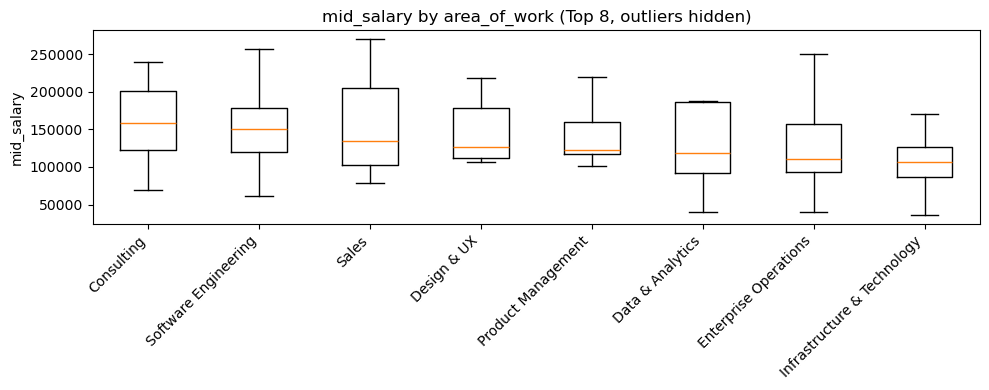

In [16]:
top_n = 8

top_areas = df3_salary["area_of_work"].value_counts().head(top_n).index.tolist()
df_area = df3_salary[df3_salary["area_of_work"].isin(top_areas)].copy()

# Summary table
area_summary = (
    df_area.groupby("area_of_work")["mid_salary"]
    .agg(n="count", median="median", mean="mean")
    .sort_values("median", ascending=False)
)
display(area_summary)

# Boxplot
plt.figure(figsize=(10, 4))
data_to_plot = [df_area.loc[df_area["area_of_work"] == a, "mid_salary"].values for a in area_summary.index]
plt.boxplot(data_to_plot, labels=area_summary.index, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("mid_salary")
plt.title(f"mid_salary by area_of_work (Top {top_n}, outliers hidden)")
plt.tight_layout()
plt.show()


In [17]:
from scipy.stats import kruskal

groups = [df_area.loc[df_area["area_of_work"] == a, "mid_salary"].dropna().values for a in area_summary.index]
kw_stat, kw_p = kruskal(*groups)

print("Kruskal-Wallis test: mid_salary by area_of_work")
print(f"H statistic = {kw_stat:.4f}")
print(f"p-value     = {kw_p:.6g}")

if kw_p < 0.001:
    print("Conclusion: There is a highly significant difference in salary distributions across different areas of work (p < 0.001).")
elif kw_p < 0.05:
    print("Conclusion: There is a significant difference in salary distributions across different areas of work (p < 0.05).")
else:
    print("Conclusion: No significant difference was observed (p ≥ 0.05).")


Kruskal-Wallis test: mid_salary by area_of_work
H statistic = 67.2498
p-value     = 5.30244e-12
Conclusion: There is a highly significant difference in salary distributions across different areas of work (p < 0.001).


## 3.2 Salary Differences Across position_type

Salary differences by position_type are very pronounced. Professional roles have the highest median (about 173.5k), while Entry Level and Internship roles are substantially lower (about 113.5k and 104.5k), and Administration & Technician has a small sample but a notably lower median (about 56k). The Kruskal–Wallis result is extremely significant (H≈295.37, p≈9.99e-64), suggesting that position type/level is one of the most important drivers of compensation differences in this dataset.


,n,median,mean
position_type,,,
Professional,270,173500.0,172221.481481
Entry Level,90,113500.0,109205.377778
Internship,100,104525.0,95326.48
Administration & Technician,10,56000.0,63550.0


C:\Users\win\AppData\Local\Temp\ipykernel_38676\3571813466.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=pos_summary.index, showfliers=False)


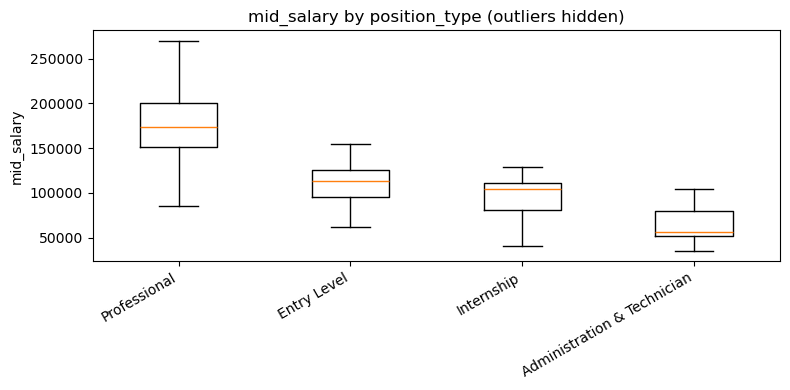

Kruskal-Wallis test: mid_salary by position_type
H statistic = 295.3713
p-value     = 9.98908e-64


In [18]:
# filter missing
df_pos = df3_salary.dropna(subset=["position_type"]).copy()

pos_summary = (
    df_pos.groupby("position_type")["mid_salary"]
    .agg(n="count", median="median", mean="mean")
    .sort_values("median", ascending=False)
)
display(pos_summary)

# Boxplot (outliers hidden)
plt.figure(figsize=(8, 4))
data_to_plot = [df_pos.loc[df_pos["position_type"] == t, "mid_salary"].values for t in pos_summary.index]
plt.boxplot(data_to_plot, labels=pos_summary.index, showfliers=False)
plt.xticks(rotation=30, ha="right")
plt.ylabel("mid_salary")
plt.title("mid_salary by position_type (outliers hidden)")
plt.tight_layout()
plt.show()

# Kruskal-Wallis
pos_groups = [df_pos.loc[df_pos["position_type"] == t, "mid_salary"].dropna().values for t in pos_summary.index]
kw_stat2, kw_p2 = kruskal(*pos_groups)

print("Kruskal-Wallis test: mid_salary by position_type")
print(f"H statistic = {kw_stat2:.4f}")
print(f"p-value     = {kw_p2:.6g}")


## 3.3 Salary and required_education

Required education shows an overall gradient with higher requirements associated with higher median salary, but the group sizes are highly imbalanced. High School Diploma/GED and Bachelor’s Degree dominate the sample and display a clear median gap (about 112k vs 158k); Master’s Degree has a higher median (about 196.5k), while Doctorate Degree appears highest but is based on a very small n and should not be over-generalized. The Kruskal–Wallis test is significant (H≈88.60, p≈1.32e-17), providing statistical evidence that salary distributions differ across required education levels.


,n,median,mean
required_education,,,
Doctorate Degree,4,237750.0,228250.0
Master's Degree,8,196500.0,187337.5
Bachelor's Degree,221,158000.0,157287.5
Associate's Degree/College Diploma,7,124800.0,122411.428571
High School Diploma/GED,218,112192.0,121340.433486
Technical Diploma,1,51500.0,51500.0


C:\Users\win\AppData\Local\Temp\ipykernel_38676\1436391092.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=edu_summary.index, showfliers=False)


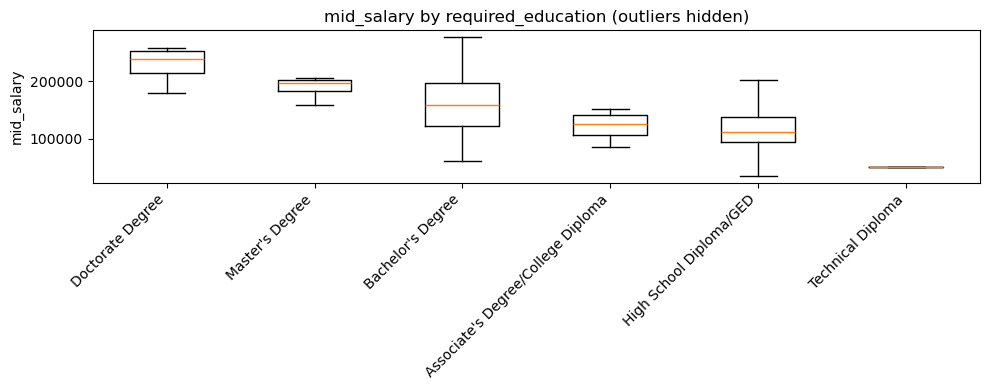

Kruskal-Wallis test: mid_salary by required_education
H statistic = 88.5993
p-value     = 1.32278e-17


In [19]:
df_edu = df3_salary.dropna(subset=["required_education"]).copy()

edu_summary = (
    df_edu.groupby("required_education")["mid_salary"]
    .agg(n="count", median="median", mean="mean")
    .sort_values("median", ascending=False)
)
display(edu_summary)

plt.figure(figsize=(10, 4))
data_to_plot = [df_edu.loc[df_edu["required_education"] == e, "mid_salary"].values for e in edu_summary.index]
plt.boxplot(data_to_plot, labels=edu_summary.index, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("mid_salary")
plt.title("mid_salary by required_education (outliers hidden)")
plt.tight_layout()
plt.show()

edu_groups = [df_edu.loc[df_edu["required_education"] == e, "mid_salary"].dropna().values for e in edu_summary.index]
kw_stat3, kw_p3 = kruskal(*edu_groups)

print("Kruskal-Wallis test: mid_salary by required_education")
print(f"H statistic = {kw_stat3:.4f}")
print(f"p-value     = {kw_p3:.6g}")


## 3.4 Association Between area_of_work and position_type

The contingency table indicates that the mix of position_type varies across area_of_work, suggesting meaningful structural differences. A chi-square test rejects independence (χ²≈112.78, dof=21, p≈1.48e-14), and Cramér’s V≈0.29 suggests a moderate association, implying that certain business areas disproportionately concentrate specific position types; this supports analyzing salary with both dimensions in mind rather than treating them as separable.

position_type,Administration & Technician,Entry Level,Internship,Professional
area_of_work,,,,
Consulting,0,14,7,95
Data & Analytics,0,4,5,7
Design & UX,0,4,5,4
Enterprise Operations,1,7,5,14
Infrastructure & Technology,9,24,39,28
Product Management,0,12,9,7
Sales,0,5,8,28
Software Engineering,0,13,21,68


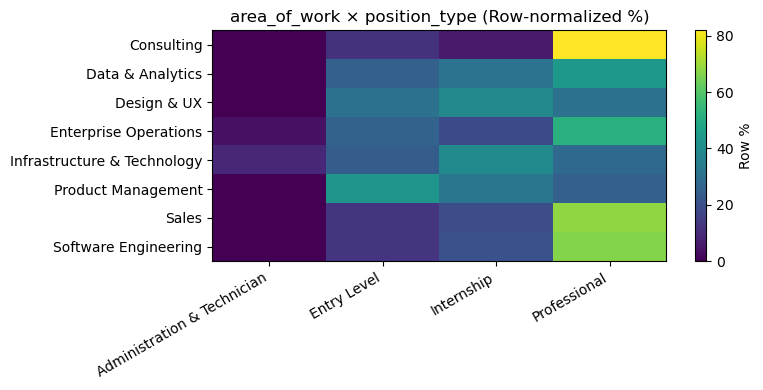

Chi-square test: area_of_work vs position_type:
chi2 = 112.7832, dof = 21, p-value = 1.47904e-14
Cramér's V = 0.2913  


In [20]:
from scipy.stats import chi2_contingency

# Use Top area_of_work，preventing matrix too big
top_areas2 = df3["area_of_work"].value_counts().head(8).index
df_cat = df3[df3["area_of_work"].isin(top_areas2)].dropna(subset=["area_of_work", "position_type"]).copy()

ct = pd.crosstab(df_cat["area_of_work"], df_cat["position_type"])
display(ct)

# Row-normalized (%)
ct_row = ct.div(ct.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 4))
plt.imshow(ct_row.values, aspect="auto")
plt.colorbar(label="Row %")
plt.xticks(range(ct_row.shape[1]), ct_row.columns, rotation=30, ha="right")
plt.yticks(range(ct_row.shape[0]), ct_row.index)
plt.title("area_of_work × position_type (Row-normalized %)")
plt.tight_layout()
plt.show()

# Chi-square
chi2, p, dof, expected = chi2_contingency(ct)
print("Chi-square test: area_of_work vs position_type:")
print(f"chi2 = {chi2:.4f}, dof = {dof}, p-value = {p:.6g}")

# Cramér's V
n = ct.values.sum()
r, k = ct.shape
cramers_v = np.sqrt((chi2 / n) / (min(r-1, k-1)))
print(f"Cramér's V = {cramers_v:.4f}  ")


## 3.5 Conclusion

Using robust summaries (medians and quantiles), salary differs significantly across business areas, position types, and required education levels, with position_type showing the strongest separation. The contingency analysis indicates that area_of_work and position_type are not independent and exhibit a moderate structural association, so salary gaps likely reflect both cross-area differences and differences in the composition of job levels within each area. For deeper explanation or modeling, position_type should be treated as a primary control variable, and stratification or interaction with area_of_work is likely informative.


# 4. Time Trends & Additional Checks

This section adds a time dimension to identify shifts in posting volume and salary levels over the observed window, and complements the analysis with outlier and missingness checks. Because the time span is relatively short and postings are concentrated near the end of the window, the discussion emphasizes descriptive evidence and reporting units, avoiding over-interpreting short-term fluctuations as long-run trends.


In [21]:
df4 = df2.copy()

if "date_posted_dt" not in df4.columns:
    df4["date_posted_dt"] = pd.to_datetime(df4["date_posted"], format="%d-%b-%Y", errors="coerce")

df4_time = df4.dropna(subset=["date_posted_dt"]).copy()
df4_time["week"] = df4_time["date_posted_dt"].dt.to_period("W").dt.start_time
df4_time["month"] = df4_time["date_posted_dt"].dt.to_period("M").dt.start_time

print("df4_time shape:", df4_time.shape)
print("Date range:", df4_time["date_posted_dt"].min().date(), "to", df4_time["date_posted_dt"].max().date())


df4_time shape: (471, 18)
Date range: 2025-08-14 to 2026-02-04


## 4.1 Posting Volume Over Time (Weekly/Monthly)

Monthly aggregation shows a strong concentration of postings in January 2026 (261), followed by February 2026 (84) and December 2025 (65), with far fewer in October (32) and November (28) 2025 and only a single posting in August. Weekly aggregation highlights a rapid ramp-up near the end of the sample: the series increases from the week of 2026-01-05 (27) to 01-12 (58) and 01-19 (61), peaks at 01-26 (115), and remains elevated in the week of 02-02 (84). Any time-trend interpretation should therefore be conditioned on the uneven posting volume over time.


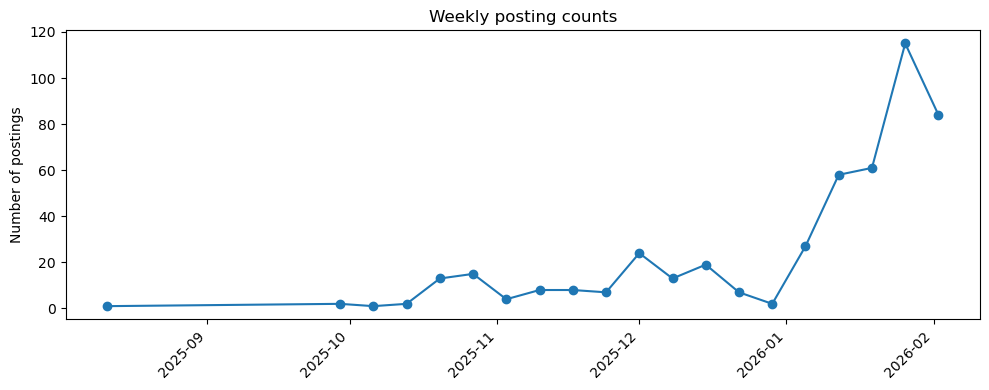

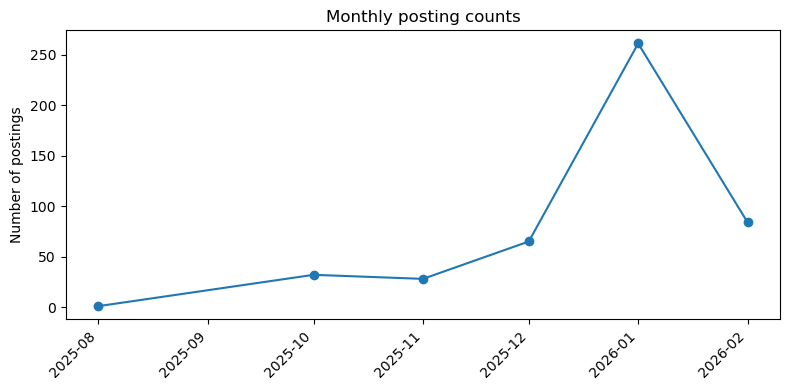

,weekly_count
week,
2025-12-01,24
2025-12-08,13
2025-12-15,19
2025-12-22,7
2025-12-29,2
2026-01-05,27
2026-01-12,58
2026-01-19,61
2026-01-26,115


,monthly_count
month,
2025-08-01,1
2025-10-01,32
2025-11-01,28
2025-12-01,65
2026-01-01,261
2026-02-01,84


In [22]:
weekly_counts = df4_time.groupby("week").size().sort_index()
monthly_counts = df4_time.groupby("month").size().sort_index()

# Weekly trend
plt.figure(figsize=(10, 4))
plt.plot(weekly_counts.index, weekly_counts.values, marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of postings")
plt.title("Weekly posting counts")
plt.tight_layout()
plt.show()

# Monthly trend
plt.figure(figsize=(8, 4))
plt.plot(monthly_counts.index, monthly_counts.values, marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of postings")
plt.title("Monthly posting counts")
plt.tight_layout()
plt.show()

display(pd.DataFrame({"weekly_count": weekly_counts}).tail(10))
display(pd.DataFrame({"monthly_count": monthly_counts}))


## 4.2 Salary Over Time (Monthly Median + IQR)

Using postings with available salary, the monthly median mid_salary is about 107.3k in Nov 2025, increases to about 120k in Dec 2025, rises further to about 155.75k in Jan 2026, and then moderates to about 141k in Feb 2026. Sample sizes are much larger in Jan–Feb, so the higher median may reflect both genuine shifts and compositional changes due to concentrated posting activity; the interquartile range also indicates wider dispersion in early 2026, with a noticeably higher upper quartile suggesting more frequent high-paying roles during that period. Given the short window and end-loaded volume, it is best framed as a short-run level shift with potential composition effects rather than a long-run trend.


,n,median,q25,q75
month,,,,
2025-08-01,1,106800.0,106800.0,106800.0
2025-10-01,32,122750.0,111384.0,150900.0
2025-11-01,28,107300.0,100937.5,126000.0
2025-12-01,65,120000.0,101190.0,158000.0
2026-01-01,260,155750.0,111500.0,183500.0
2026-02-01,84,141000.0,107100.0,187375.0


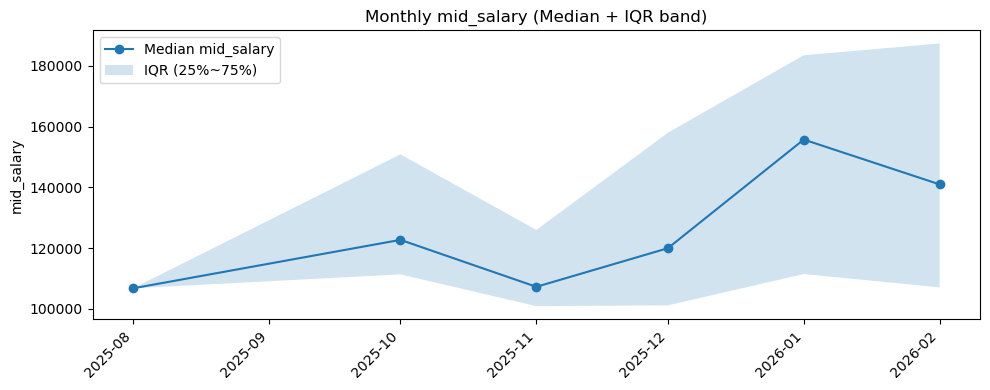

In [23]:
df4_sal = df4_time.dropna(subset=["mid_salary"]).copy()

monthly_salary = df4_sal.groupby("month")["mid_salary"].agg(
    n="count",
    median="median",
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
).sort_index()

display(monthly_salary)

# Plot median line + IQR band
plt.figure(figsize=(10, 4))
plt.plot(monthly_salary.index, monthly_salary["median"].values, marker="o", label="Median mid_salary")
plt.fill_between(
    monthly_salary.index,
    monthly_salary["q25"].values,
    monthly_salary["q75"].values,
    alpha=0.2,
    label="IQR (25%~75%)"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("mid_salary")
plt.title("Monthly mid_salary (Median + IQR band)")
plt.tight_layout()
plt.legend()
plt.show()


## 4.3 Salary Trends by area_of_work (Top 4)

To reduce noise from very small groups, this subsection focuses on the four most frequent area_of_work categories and compares their monthly median salary trajectories. The main goal is not month-by-month micro-fluctuations, but whether there is a persistent ranking across areas and whether the January 2026 posting surge coincides with a level shift or divergence between areas. When a business area shows a clear median uplift in Jan–Feb alongside a jump in volume, it often points to a compositional change toward more senior or higher-paying roles, which should be interpreted together with the position_type mix.


area_of_work,Consulting,Infrastructure & Technology,Sales,Software Engineering
month,,,,
2025-10-01,18,8,1,1
2025-11-01,3,9,5,3
2025-12-01,8,23,2,11
2026-01-01,69,50,25,65
2026-02-01,18,10,8,22


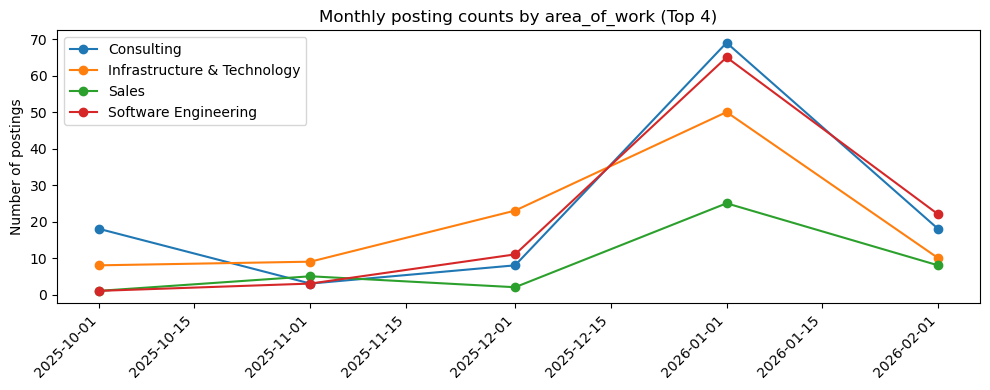

In [24]:
top_k = 4
top_areas = df4_time["area_of_work"].value_counts().head(top_k).index.tolist()

df_area_time = df4_time[df4_time["area_of_work"].isin(top_areas)].copy()
area_month_counts = pd.crosstab(df_area_time["month"], df_area_time["area_of_work"]).sort_index()

display(area_month_counts)

plt.figure(figsize=(10, 4))
for col in area_month_counts.columns:
    plt.plot(area_month_counts.index, area_month_counts[col].values, marker="o", label=col)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of postings")
plt.title(f"Monthly posting counts by area_of_work (Top {top_k})")
plt.tight_layout()
plt.legend()
plt.show()


## 4.4 Outliers and Extreme Salary Checks

The salary fields contain a small number of extreme values (for example, the maximum max_salary_num reaches 410k), which can disproportionately influence mean-variance summaries. For interpretability and robustness, medians and quantiles are preferred, and the highest-salary postings are worth a quick manual validation by checking whether the job title, business area, and position type plausibly align with the pay level while also confirming internal consistency between min_salary_num and max_salary_num. If modeling is pursued later, techniques such as log transforms, winsorization, or robust regression can reduce sensitivity to extremes without dropping observations.


In [25]:
df_out = df4_time.dropna(subset=["mid_salary"]).copy()

q1 = df_out["mid_salary"].quantile(0.25)
q3 = df_out["mid_salary"].quantile(0.75)
iqr = q3 - q1

low_thr = q1 - 1.5 * iqr
high_thr = q3 + 1.5 * iqr

outliers = df_out[(df_out["mid_salary"] < low_thr) | (df_out["mid_salary"] > high_thr)].copy()

print("Outlier detection (IQR) on mid_salary")
print(f"Q1={q1:,.0f}, Q3={q3:,.0f}, IQR={iqr:,.0f}")
print(f"Lower threshold={low_thr:,.0f}, Upper threshold={high_thr:,.0f}")
print(f"Outlier count={len(outliers)} out of {len(df_out)} ({len(outliers)/len(df_out)*100:.2f}%)")

# Top high / low salary examples
cols_show = ["job_id", "job_title", "date_posted", "state_province", "area_of_work", "position_type", "min_salary_num", "max_salary_num", "mid_salary", "salary_range"]

top_high = df_out.sort_values("mid_salary", ascending=False).head(10)[cols_show]
top_low = df_out.sort_values("mid_salary", ascending=True).head(10)[cols_show]

print("\nTop 10 highest mid_salary:")
display(top_high)

print("\nTop 10 lowest mid_salary:")
display(top_low)


Outlier detection (IQR) on mid_salary
Q1=107,100, Q3=178,500, IQR=71,400
Lower threshold=0, Upper threshold=285,600
Outlier count=1 out of 470 (0.21%)

Top 10 highest mid_salary:


,job_id,job_title,date_posted,state_province,area_of_work,position_type,min_salary_num,max_salary_num,mid_salary,salary_range
348,89533,"Principal Engineer, Db2 for z/OS",04-Feb-2026,California,Software Engineering,Professional,275000.0,410000.0,342500.0,135000.0
300,80088,Software Engineer - Streaming,03-Feb-2026,"Texas, Massachusetts, California",Software Engineering,Professional,220800.0,331200.0,276000.0,110400.0
71,86223,Ecosystem Technical Strategist,23-Jan-2026,"Texas, New York, California",Sales,Professional,162000.0,378000.0,270000.0,216000.0
377,90520,Senior Quantum Error Correction Theorist,03-Feb-2026,New York,Research,Professional,219000.0,296000.0,257500.0,77000.0
307,72905,Senior Digital Asset Sales,03-Feb-2026,New York,Sales,Professional,243000.0,270000.0,256500.0,27000.0
10,72906,Senior Digital Asset Tech Sales,20-Jan-2026,New York,Sales,Professional,243000.0,270000.0,256500.0,27000.0
155,87906,Staff Software Engineer - HashiCorp Secure Run...,27-Jan-2026,"Texas, Massachusetts, California",Software Engineering,Professional,189000.0,324000.0,256500.0,135000.0
457,83085,Staff Engineer-Full Stack-HCP Terraform Founda...,05-Jan-2026,"Texas, North Carolina, Massachusetts, California",Software Engineering,Professional,189000.0,324000.0,256500.0,135000.0
121,81989,U.S. Public Sector Compliance Officer,20-Dec-2025,"Texas, New York, Virginia, Alabama, Colorado, ...",Enterprise Operations,Professional,184000.0,317000.0,250500.0,133000.0
43,85759,Industry Quantum Consultant,12-Jan-2026,New York,Consulting,Professional,200000.0,280000.0,240000.0,80000.0



Top 10 lowest mid_salary:


,job_id,job_title,date_posted,state_province,area_of_work,position_type,min_salary_num,max_salary_num,mid_salary,salary_range
55,90253,Tier 1 Help Desk Analyst,03-Feb-2026,"Virginia, Maryland, West Virginia, District of...",Infrastructure & Technology,Administration & Technician,33000.0,38000.0,35500.0,5000.0
21,87269,Data Engineer Intern 2026 – Client Innovation ...,16-Jan-2026,"New York, Michigan, Louisiana",Data & Analytics,Internship,29120.0,51484.0,40302.0,22364.0
170,87026,Data Scientist Intern 2026 – Client Innovation...,19-Jan-2026,New York,Enterprise Operations,Internship,29120.0,51484.0,40302.0,22364.0
419,87033,Package Specialist Intern 2026 – Client Innova...,16-Jan-2026,"Michigan, Louisiana",Infrastructure & Technology,Internship,29120.0,51484.0,40302.0,22364.0
416,76379,"System Services Representatives - San Antonio, TX",23-Dec-2025,Texas,Infrastructure & Technology,Administration & Technician,33000.0,57000.0,45000.0,24000.0
402,89490,System Services Representative,04-Feb-2026,Illinois,Infrastructure & Technology,Administration & Technician,37000.0,66000.0,51500.0,29000.0
17,86493,"System Services Representative - Monroe, LA",21-Jan-2026,Louisiana,Infrastructure & Technology,Administration & Technician,37000.0,66000.0,51500.0,29000.0
119,79935,System Services Representative - Nashville,30-Dec-2025,Tennessee,Infrastructure & Technology,Administration & Technician,37000.0,66000.0,51500.0,29000.0
114,64174,Mainframe System Verification Tester Apprentice,12-Dec-2025,New York,Infrastructure & Technology,Internship,49200.0,54120.0,51660.0,4920.0
131,88938,Infrastructure Lab Technician Apprentice,02-Feb-2026,New York,Infrastructure & Technology,Internship,49200.0,54120.0,51660.0,4920.0


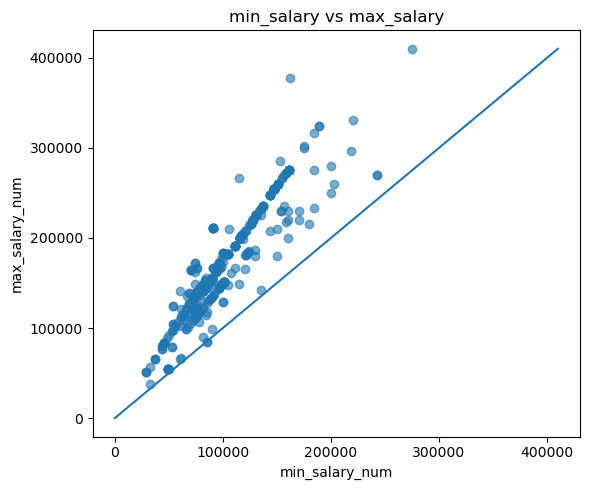

In [26]:
df_scatter = df4_time.dropna(subset=["min_salary_num", "max_salary_num"]).copy()

plt.figure(figsize=(6, 5))
plt.scatter(df_scatter["min_salary_num"], df_scatter["max_salary_num"], alpha=0.6)
mx = max(df_scatter["max_salary_num"].max(), df_scatter["min_salary_num"].max())
plt.plot([0, mx], [0, mx])  # 45-degree line
plt.xlabel("min_salary_num")
plt.ylabel("max_salary_num")
plt.title("min_salary vs max_salary")
plt.tight_layout()
plt.show()


In [27]:
df_range = df4_time.dropna(subset=["salary_range", "mid_salary"]).copy()

zero_range = df_range[df_range["salary_range"] == 0]
print("salary_range == 0 count:", len(zero_range), f"({len(zero_range)/len(df_range)*100:.2f}%)")

thr_range = df_range["salary_range"].quantile(0.99)
large_range = df_range[df_range["salary_range"] >= thr_range].sort_values("salary_range", ascending=False)

print("Top 1% salary_range threshold:", f"{thr_range:,.0f}")
display(large_range[["job_id","job_title","area_of_work","position_type","min_salary_num","max_salary_num","salary_range"]].head(15))


salary_range == 0 count: 2 (0.43%)
Top 1% salary_range threshold: 133,620


,job_id,job_title,area_of_work,position_type,min_salary_num,max_salary_num,salary_range
71,86223,Ecosystem Technical Strategist,Sales,Professional,162000.0,378000.0,216000.0
118,77937,Software Engineer - Opensearch,Software Engineering,Professional,114500.0,267100.0,152600.0
155,87906,Staff Software Engineer - HashiCorp Secure Run...,Software Engineering,Professional,189000.0,324000.0,135000.0
348,89533,"Principal Engineer, Db2 for z/OS",Software Engineering,Professional,275000.0,410000.0,135000.0
457,83085,Staff Engineer-Full Stack-HCP Terraform Founda...,Software Engineering,Professional,189000.0,324000.0,135000.0


## 4.5 Group Differences in Missingness

Overall missingness is much higher in preferred_education and preferred_technical_experience than in most other fields, and the grouped results suggest the missingness is not purely random: missing rates vary across business areas and position types, with some groups exceeding the overall averages. This implies that comparisons using “preferred” fields should always report sample sizes and missing rates, and should not interpret missing as “no requirement.” A safer reporting stance is to treat missing as “not disclosed / not provided” and note that these fields partly capture how detailed the posting text is, not only the underlying job requirements.


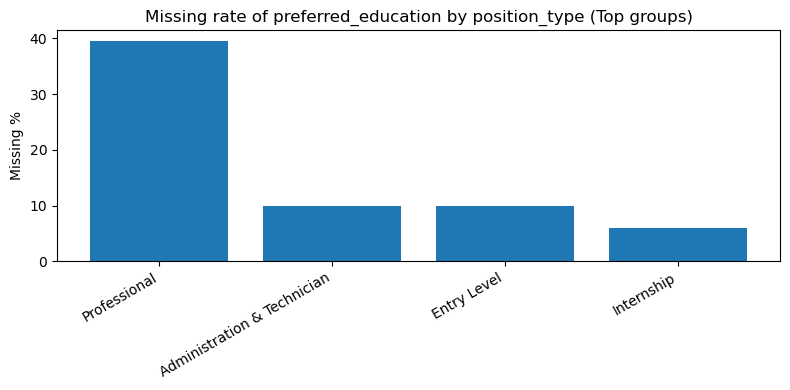

,missing_pct
position_type,
Professional,39.483395
Administration & Technician,10.000000
Entry Level,10.000000
Internship,6.000000


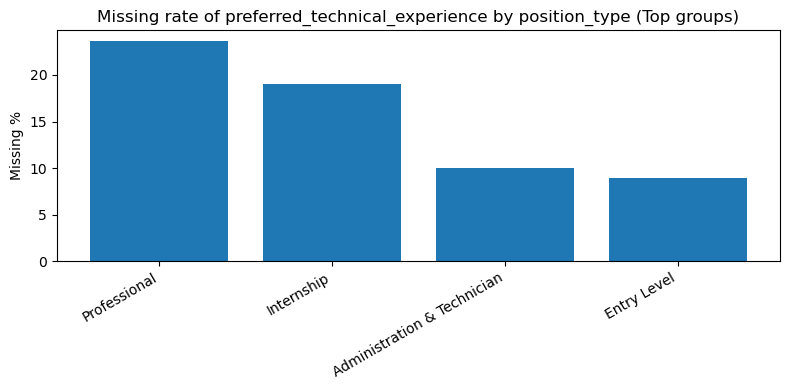

,missing_pct
position_type,
Professional,23.616236
Internship,19.000000
Administration & Technician,10.000000
Entry Level,8.888889


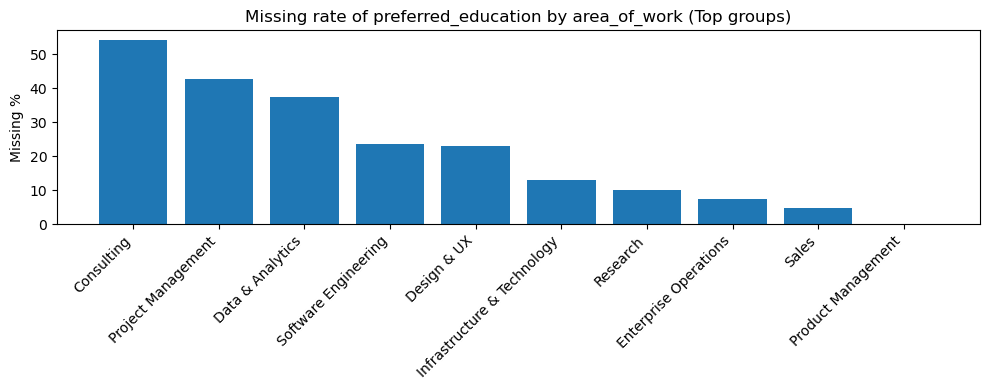

,missing_pct
area_of_work,
Consulting,54.310345
Project Management,42.857143
Data & Analytics,37.500000
Software Engineering,23.529412
Design & UX,23.076923
Infrastructure & Technology,13.000000
Research,10.000000
Enterprise Operations,7.407407
Sales,4.878049


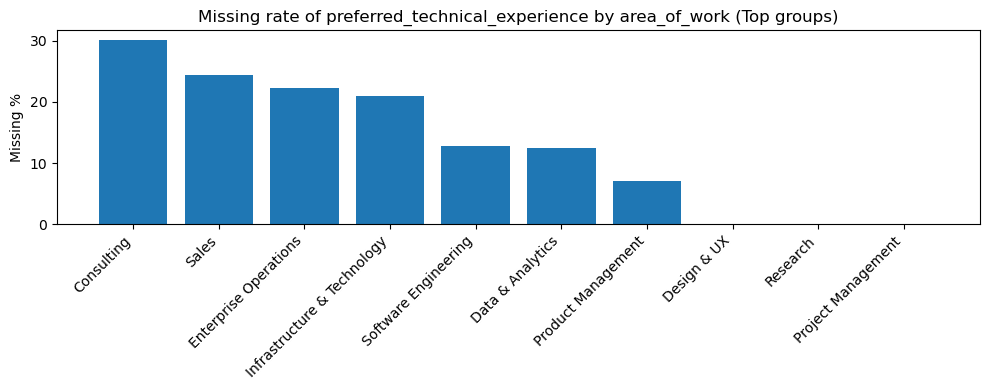

,missing_pct
area_of_work,
Consulting,30.172414
Sales,24.390244
Enterprise Operations,22.222222
Infrastructure & Technology,21.000000
Software Engineering,12.745098
Data & Analytics,12.500000
Product Management,7.142857
Design & UX,0.000000
Research,0.000000


In [28]:
def missing_rate_by_group(df, group_col, target_col, top_n=10):
    tmp = df.dropna(subset=[group_col]).copy()
    # only show top_n
    top_groups = tmp[group_col].value_counts().head(top_n).index
    tmp = tmp[tmp[group_col].isin(top_groups)]
    out = tmp.groupby(group_col)[target_col].apply(lambda x: x.isna().mean() * 100).sort_values(ascending=False)
    return out

# By position_type
mr_pos_prefedu = missing_rate_by_group(df4, "position_type", "preferred_education", top_n=10)
mr_pos_preftech = missing_rate_by_group(df4, "position_type", "preferred_technical_experience", top_n=10)

plt.figure(figsize=(8,4))
plt.bar(mr_pos_prefedu.index, mr_pos_prefedu.values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Missing %")
plt.title("Missing rate of preferred_education by position_type (Top groups)")
plt.tight_layout()
plt.show()
display(mr_pos_prefedu.to_frame("missing_pct"))

plt.figure(figsize=(8,4))
plt.bar(mr_pos_preftech.index, mr_pos_preftech.values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Missing %")
plt.title("Missing rate of preferred_technical_experience by position_type (Top groups)")
plt.tight_layout()
plt.show()
display(mr_pos_preftech.to_frame("missing_pct"))

# By area_of_work
mr_area_prefedu = missing_rate_by_group(df4, "area_of_work", "preferred_education", top_n=10)
mr_area_preftech = missing_rate_by_group(df4, "area_of_work", "preferred_technical_experience", top_n=10)

plt.figure(figsize=(10,4))
plt.bar(mr_area_prefedu.index, mr_area_prefedu.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing %")
plt.title("Missing rate of preferred_education by area_of_work (Top groups)")
plt.tight_layout()
plt.show()
display(mr_area_prefedu.to_frame("missing_pct"))

plt.figure(figsize=(10,4))
plt.bar(mr_area_preftech.index, mr_area_preftech.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing %")
plt.title("Missing rate of preferred_technical_experience by area_of_work (Top groups)")
plt.tight_layout()
plt.show()
display(mr_area_preftech.to_frame("missing_pct"))


## 4.6 Conclusion

Posting volume is heavily end-loaded, with a large concentration in January 2026, so short-run trends are best interpreted as a mixture of timing effects and compositional shifts rather than long-run patterns. Monthly median salary rises in early 2026 and dispersion widens, suggesting high-paying postings become more frequent during that period, but the interpretation should be tied back to changes in position_type and area_of_work composition. In addition, missingness in preferred fields varies by group, so any conclusions involving these variables should explicitly acknowledge reporting units, missingness behavior, and the resulting limitations to maintain robustness and reproducibility.
